<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод-исследования" data-toc-modified-id="Общий-вывод-исследования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод исследования</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

В нашем распоряжении исторические данные о заказах такси в аэропортах

Необходимо построить модель предсказания количество заказов такси на следующий час для привлечения большего кол-ва водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


In [1]:
# устанавливаем библиотеки
!pip install lightgbm

In [2]:
# импортируем библиотеки
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

## Подготовка

### Обзор данных

**Откроим файл с данными, изучим общую информацию.**

In [3]:
pth1 = '/datasets/taxi.csv'
pth2 = 'https://restricted/datasets/taxi.csv'

def open_df(pth):
    return pd.read_csv(pth, index_col=[0], parse_dates=[0])

if os.path.exists(pth1):
    data = open_df(pth1)
else:
    try:
        data = open_df(pth2)
    except:
        print('Something is wrong, datasets not found!!!')

In [4]:
# Выведем общую инф о df
def df_info(df):
    display(df.head())
    display(df.info())
    display(df.describe())

In [5]:
df_info(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


В столбце `num_orders` представлено количество заказов в 26496 строках

Пропуски в данных отсутствуют

### Предобработка данных

Проверим расположены ли даты и время в хронологическом порядке

In [6]:
if data.index.is_monotonic:
    print("даты и время в хронологическом порядке")
else:
    data.sort_index(inplace=True)
    print("индексы отсортированы")

даты и время в хронологическом порядке


Проведем ресемплирование данных по одному часу

In [7]:
data = data.resample('1H').sum()

На данном этапе произведена загрузка данных и их подготовка:
- На этапе открытия данных был изменен индекс таблицы и тип данных;
- Данные представлены в `num_orders` в количестве 354369;
- Пропуски не выявлены;
- Произведено ресемплирование данных по одному часу.

## Анализ

In [8]:
print('Минимальная дата:',data.index.min())
print('Максимальная дата:',data.index.max())
print('Временной период:',data.index.max() - data.index.min())

Минимальная дата: 2018-03-01 00:00:00
Максимальная дата: 2018-08-31 23:00:00
Временной период: 183 days 23:00:00


Визуализируем данные

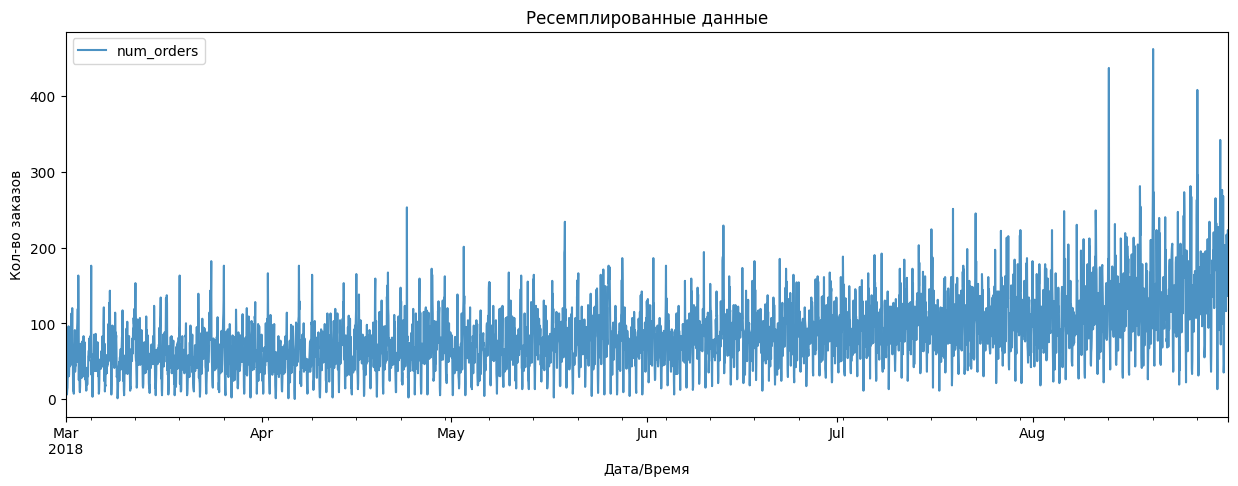

In [9]:
data.plot(figsize=(15, 5), alpha=0.8)
plt.title('Ресемплированные данные')
plt.xlabel('Дата/Время')
plt.ylabel('Кол-во заказов')
plt.show()

Чтобы лучше понять временной ряд разложим его на три составляющие: тренд, сезонность и остаток.

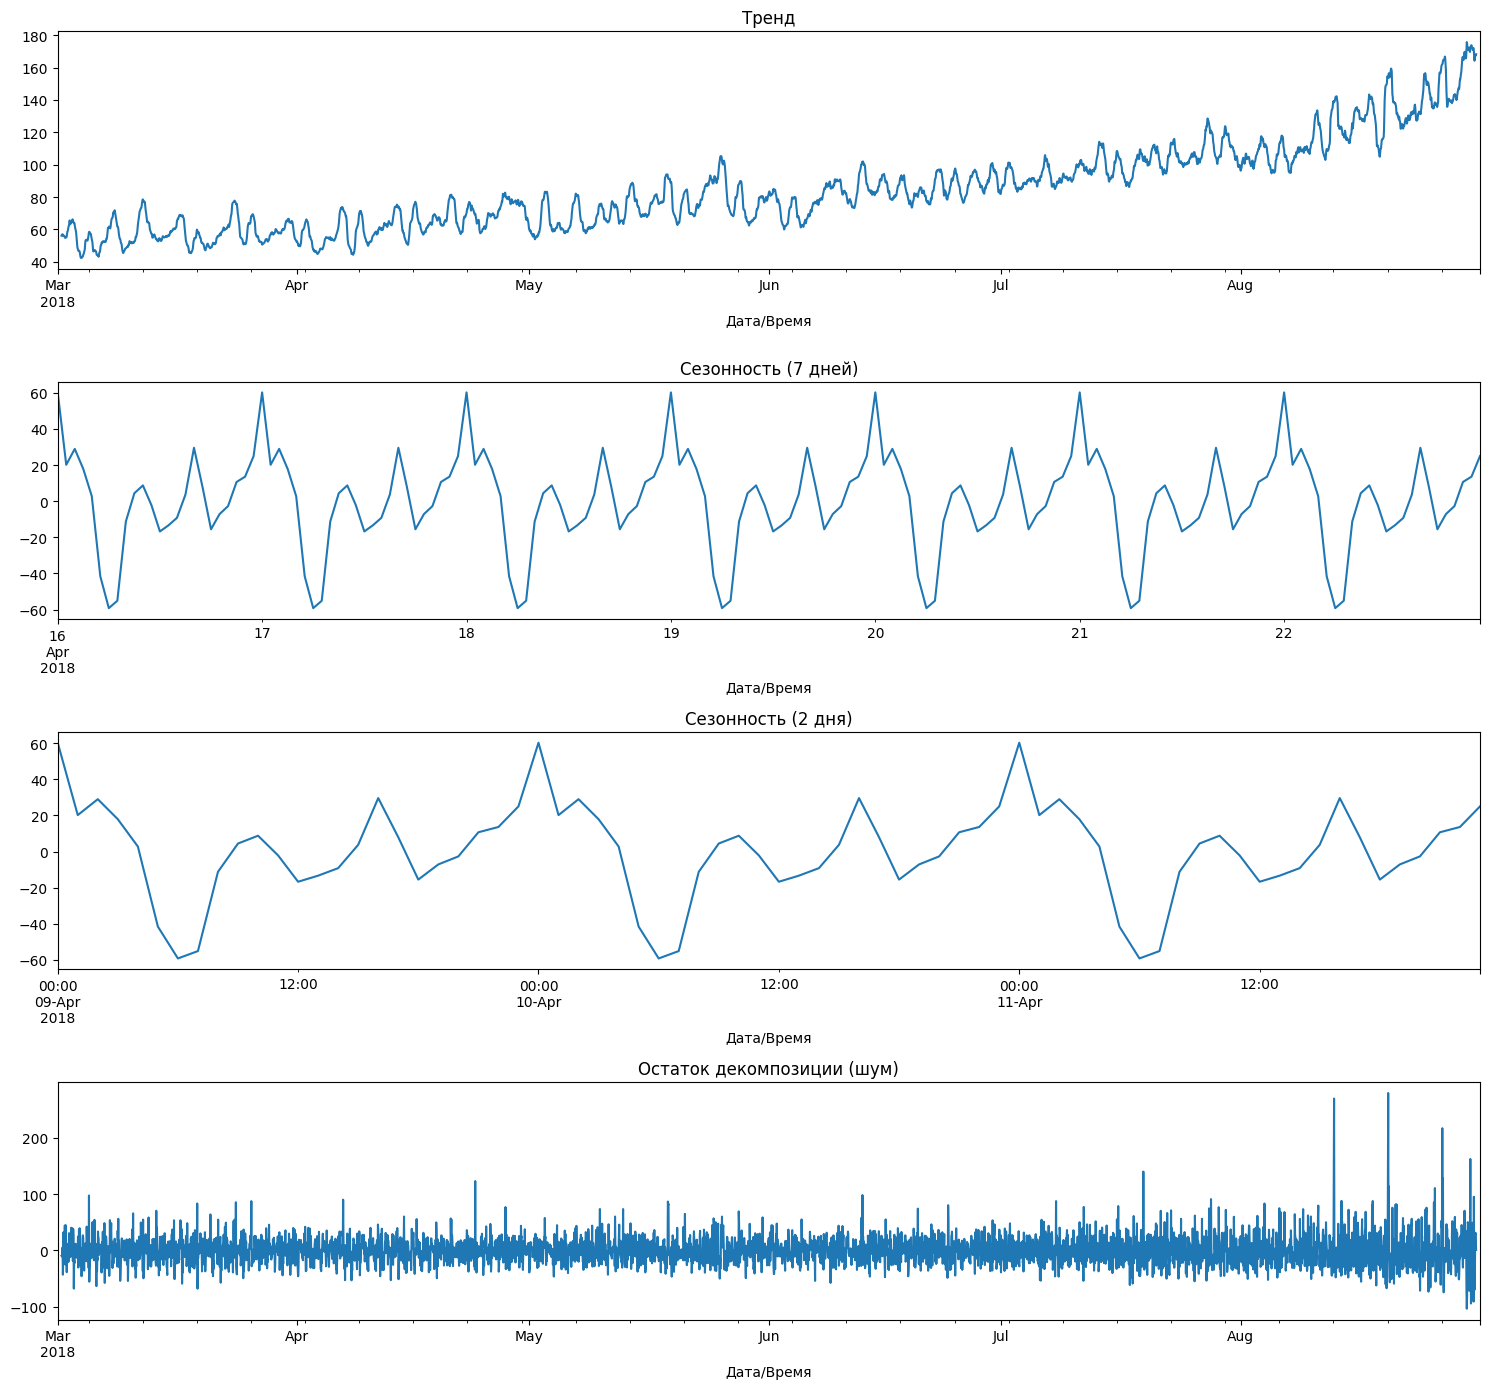

In [10]:
decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(15, 14))

#строим график тренда
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата/Время')

#строим график сезонности для одной недели
plt.subplot(412)
decomposed.seasonal['2018-04-16':'2018-04-22'].plot(ax=plt.gca())
plt.title('Сезонность (7 дней)')
plt.xlabel('Дата/Время')

#строим график сезонности для двух дней
plt.subplot(413)
decomposed.seasonal['2018-04-09':'2018-04-11'].plot(ax=plt.gca())
plt.title('Сезонность (2 дня)')
plt.xlabel('Дата/Время')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции (шум)')
plt.xlabel('Дата/Время')
plt.tight_layout()

Визуально наблюдается небольшой рост тренда.  
Присутствует явная сезонность: С 00-00 ночи и до 6-00 утра количество заказов уменьшается, затем наблюдается рост с пиками в 11-00, 15-00 и максимумом в 00-00, далее процесс повторяется.

Построим графики ACF и PCF которые позволят визуально определить количество «Отстающих значений» и глубину скользящего среднего

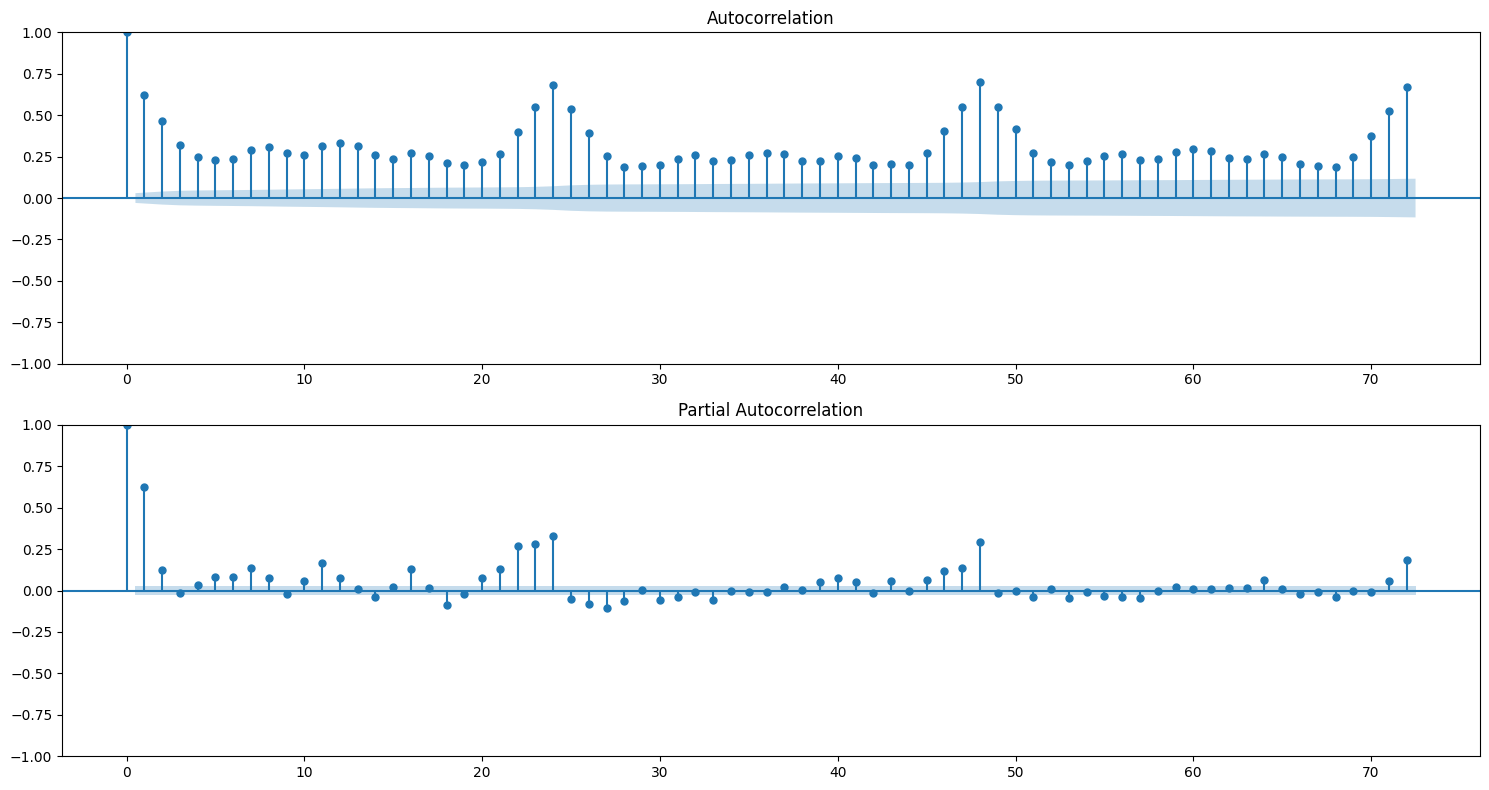

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
plot_acf(data, ax=plt.gca(), lags=24*3)
plt.subplot(212)
plot_pacf(data, method='yw', ax=plt.gca(), lags=24*3)
plt.tight_layout()

График ACF показыает окно в 24 лага, PCF глубину скользящего среднего в 7, 11, 16, 24.  
Используем эти данные при подборе параметров.

В ходе анализа:
- Определили временной диапозон предоставленных данных;
- Разделили данные на три составляющие: тренд, сезонность и остаток:
  - Визуально выявили небольшой рост тренда;
  - Определили сезонность.
- Построили графики ACF и PCF, тем самым наметили количество «Отстающих значений» и глубину скользящего среднего.

## Обучение

Создадим признаки, разделим исходные данные на обучающую и тестовую выборки в соотношении 90:10

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df = df.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.weekday.isin([5,6])*1
    df['hour'] = df.index.hour
        
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [13]:
lag = 24
rolling = 7 #7, 11, 16, 24.

# Подготовим признаки
data_tng = make_features(data, lag, rolling)
data_tng = data_tng.dropna()
features = data_tng.drop(['num_orders'], axis=1)
target = data_tng['num_orders']

# Разделим данные
(features_train, features_test, 
     target_train, target_test) = train_test_split(features, target,
                                                     shuffle=False,
                                                     test_size=0.1)
print("Размерность тренеровочных данных", features_train.shape)
print("Размерность тестовых данных", features_test.shape)

Размерность тренеровочных данных (3952, 30)
Размерность тестовых данных (440, 30)


Проведем обучение трех моделей: LinearRegression, RandomForestRegressor, LGBMRegressor

In [14]:
# Cоздадим кросс-валидатор для временного ряда при помощи `TimeSeriesSplit`
tscv = TimeSeriesSplit(n_splits=3)

Модель на основе линейной регрессии

In [15]:
%%time
model_lrg = LinearRegression(n_jobs=-1)

scores = cross_val_score(model_lrg, features_train, target_train,
                         scoring='neg_root_mean_squared_error', cv=tscv)

cv_lrg_best_score = round(-np.mean(scores), 6)

cv_lrg_results = ['LinearRegression', 
                  cv_lrg_best_score]

print("score", cv_lrg_best_score)

score 27.507456
CPU times: total: 15.6 ms
Wall time: 44 ms


Модель на основе Случайного леса

In [16]:
%%time
model_rfr = RandomForestRegressor(random_state=12345)

param_grid_rfr = {
      'n_estimators': range(10, 210, 50),
      'max_depth' : [None] + [i for i in range(2, 11)]
}

# Обучение
cv_rfr = GridSearchCV(estimator=model_rfr, 
                      param_grid=param_grid_rfr, 
                      cv=tscv,
                      n_jobs=-1,
                      scoring='neg_root_mean_squared_error',
                      verbose=10
                     )
cv_rfr.fit(features_train, target_train)

cv_rfr_best_params = cv_rfr.best_params_
cv_rfr_best_score = round(-cv_rfr.best_score_, 6)

cv_rfr_results = ['RandomForest', 
                  cv_rfr_best_score]

print("best params", cv_rfr_best_params, "score", cv_rfr_best_score)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
best params {'max_depth': None, 'n_estimators': 160} score 26.818797
CPU times: total: 8.08 s
Wall time: 34.5 s


Модель LightGBM для градиентного бустинга

In [17]:
%%time

model_lgb = LGBMRegressor()

param_grid_lgb = {
    'max_depth': [25, 50],
    'learning_rate' : [0.01, 0.03],
    'n_estimators': range(10, 800, 50),
}

cv_lgb = GridSearchCV(estimator=model_lgb, 
                      param_grid=param_grid_lgb, 
                      cv=tscv,
                      n_jobs=-1,
                      scoring='neg_root_mean_squared_error',
                      verbose=10
                     )
cv_lgb.fit(features_train, target_train)

cv_lgb_best_params = cv_lgb.best_params_
cv_lgb_best_score = round(-cv_lgb.best_score_, 6)

cv_lgb_results = ['LightGBM', 
                  cv_lgb_best_score]

print("best params", cv_lgb_best_params, "score", cv_lgb_best_score)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
best params {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 710} score 26.526482
CPU times: total: 3.66 s
Wall time: 23.5 s


Сведем данные полученные в ходе обучения и кросвалидации моделей в таблицу

In [18]:
model_analytics = pd.DataFrame([cv_lrg_results, cv_rfr_results, cv_lgb_results], 
                        columns=['Модель', 'Качество предсказания (RMSE)'])
model_analytics

,Модель,Качество предсказания (RMSE)
0,LinearRegression,27.507456
1,RandomForest,26.818797
2,LightGBM,26.526482


Исследование проводилось для трех моделей: `LinearRegression`, `RandomForestRegressor`, `LGBMRegressor`.  
В результате при помощи `GridSearchCV` были подобраны оптимальные параметры, проведено обучение моделей и оценка качества моделей метрикой RMSE.  
Наилучшее качество при кросвалидации показала модель на основе `LGBMRegressor`.

## Тестирование

Проведем финальное тестирование модели

In [19]:
# функция для анализа моделей
def model_analysis (features_train, target_train, features_test, target_test, model, model_name):
    start = time.time()    
    model.fit(features_train, target_train)
    end = time.time()
    fit_time = end - start
    
    start = time.time()
    model_pred = model.predict(features_test)
    end = time.time()
    pred_time = end - start
    
    rmse = round(mean_squared_error(target_test, model_pred, squared = False), 6)
    
    return [model_name, rmse, fit_time, pred_time, model_pred]

In [20]:
model_lgb = LGBMRegressor(**cv_lgb_best_params)
model = model_analysis(features_train, target_train, features_test, target_test, model_lgb, 'LightGBM')

print('Модель:', model[0], 
     '\nКачество предсказания (RMSE):', model[1],
     '\nВремя обучения модели:', model[2], 'сек.',
     '\nВремя предсказания модели:', model[3], 'сек.',
     )

Модель: LightGBM 
Качество предсказания (RMSE): 39.765486 
Время обучения модели: 0.5669946670532227 сек. 
Время предсказания модели: 0.004998922348022461 сек.


Визуализируем работу модели

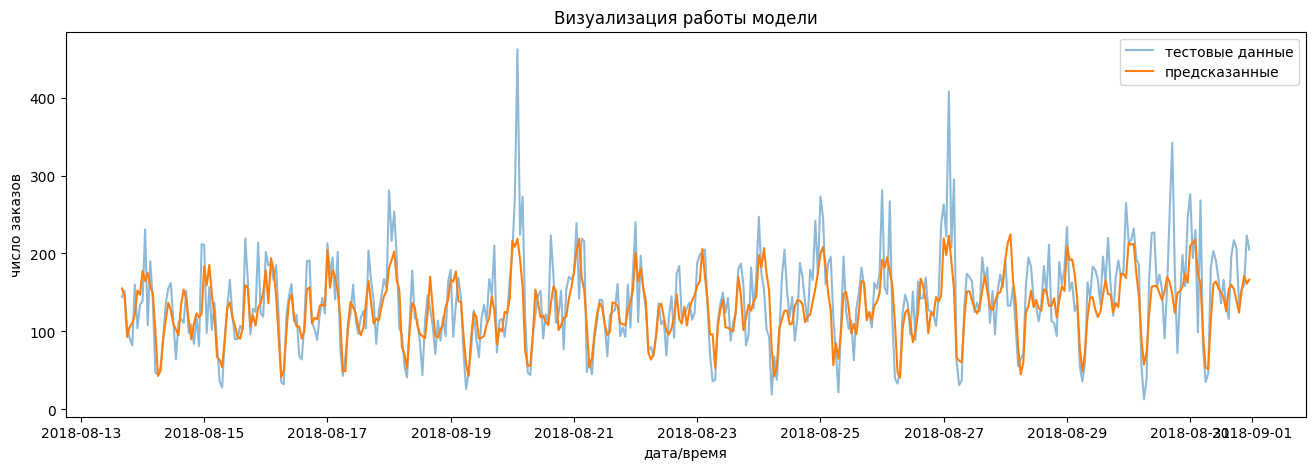

In [21]:
predict_test = pd.Series(model[4], index=target_test.index)
plt.figure(figsize=(16, 5))
plt.title('Визуализация работы модели')
plt.xlabel('дата/время')
plt.ylabel('число заказов')
plt.plot(target_test, alpha=0.5, label='тестовые данные')
plt.plot(predict_test, label='предсказанные')
plt.legend()
plt.show()

Опираясь на требования заказчика, для дальнейшей работы рекомендуем применять модель на основе `LGBMRegressor` со следующими гиперпараметрами {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 710}

## Общий вывод исследования

В нашем распоряжении исторические данные о заказах такси в аэропортах, компании «Чётенькое такси»  
Перед нами была поставлена задача:  
**Построить модель предсказания количество заказов такси на следующий час для привлечения большего кол-ва водителей в период пиковой нагрузки.**  

Из особенностей:
- Размер тестовой выборки - 10% от исходных данных;
- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Работа проходила в несколько этапов:
1. Подготовка данных:
    - Обзор данных:
        - На этапе открытия данных был изменен индекс таблицы и тип данных;
        - Данные представлены в столбце `num_orders` в количестве 354369 записей;
        - Пропуски в данных отсутствуют.
    - Предобработка данных:
        - Осуществлена проверка на монолитность данных;
        - Проведено ресемплирование данных по одному часу.
2. Анализ данных:
    - Определили временной диапозон предоставленных данных;
    - Разделили данные на три составляющие: тренд, сезонность и остаток:
        - Визуально выявили небольшой рост тренда;
        - Определили сезонность.
    - Построили графики ACF и PCF, тем самым наметили количество «Отстающих значений» и глубину скользящего среднего.
3. Обучение моделей:
    - Подготовка данных:
        - Создали признаки;
        - Разделим исходные данные на обучающую и тестовую выборки в соотношении 90:10
    - При помощи `cross_val_score` и `GridSearchCV` провели обучение с кросвалидацией для следующих моделей:
        - LinearRegression;
        - RandomForestRegressor;
        - LGBMRegressor.
    - На основе на основе метрики RMSE, выявленой при кросвалидации, выбрали лучшую модель - `LGBMRegressor`
4. Провели финальное тестирование модели на тестовой выборке:
    - Модель LightGBM: 
        - Качество предсказания (RMSE): 39.765486;
        - Время обучения модели: 0.5669946670532227 сек;
        - Время предсказания модели: 0.004998922348022461 сек;
        - Гиперпараметры: гиперпараметрами {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 710}.
    - Визуализировали результаты работы модели

Таким образом поставленная задача реализована с учетом особенностей и пожеланием заказчика.